# Training, deploying and testing a SageMaker AutoPilot job

In this example notebook we are going to train an AutoPilot job to create a multiclass classification problem. 

## Why AutoML?
In many use cases and scenarios machine learning is a great tool for some key users but they probably are not ready to apply it. Their knowledge on the problem and the data can be very rich and can produce very helpful insights for businesses, but they do not know enough about ML methodology nor feature engineering to work in a machine learning workflow. AutoML will help them to extend their knowledge domain, allowing them to apply some classification or regression models on a dataset and reaching some good results with no relevant effort. 

AutoML is related to produce machine learning solutions without doing data science tasks like data processing, feature selection, model selection, model training and deploying. Some AutoML tools are intended to boost the performence of our ML experiments on a dataset, using very advanced techniques and data preprocessing tasks but some others are focused on bringing the ML experience to a user in just a few clicks producing an initial model, a baseline model. But later the user or a more advanced user can improve the ML workflow and compare the performance of new experiments to the baseline model.

As machine learning is getting more and more attention, these tools have become a must in the portfolio of the great tech companies like Amazon Web Services.

## Introduction about Amazon SageMaker AutoPilot
Amazon SageMaker package contains the AutoPilot toolkit, a very easy and simple framework to launch AutoML projects. You just need a bunch of data files, choose your target feature and wait for AutoPilot to process your data and return a predictive model with a good enough performance. Even you can deploy the model in one click, providing your users with a REST service to test your solution.

One of the most interesting features of AutoPilot is the **visibility in the data processing and model tuning stages** it provides. You can get two notebooks: one for the data analysis and another one for data processing, model building and tuning process. As a result, you can analyze and include your own techniques or knowledge to the notebooks and even run your own experiments trying to outperform the results.

Previously we trained a job using the SageMaker Studio UI, where in a few clicks we launch a training job. SageMaker analysed the data, create different preprocessed datasets and tune some models to obtain a classifier with a really good performance.

### Importing the libraries

In [1]:
import sagemaker
from sagemaker.automl.automl import AutoML, AutoMLInput

print (sagemaker.__version__)

import pandas as pd

2.41.0


### Exploring the dataset

Our dataset is already stored in S3 but we will take a look to the train dataset to get some insights

In [2]:
train_df= pd.read_csv('train_full.csv', header=0)
train_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,38098.000000,38098.000000,38098.000000,38098.000000,38098.000000,38098.000000,38098.000000,38098.000000,38098.000000,38098.000000
mean,40.027875,258.127566,2.562129,962.300987,0.173474,0.083332,93.576648,-40.503958,3.621932,5167.026925
std,10.415106,259.071023,2.756325,187.342349,0.496900,1.569926,0.578445,4.622299,1.734393,72.294845
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Lets check if the dataset is balanced, but we guessed it is not balanced. This is an de facto example of unbalanced dataset: predict if a bank client will subscribe a deposit.

Text(0, 0.5, 'Count')

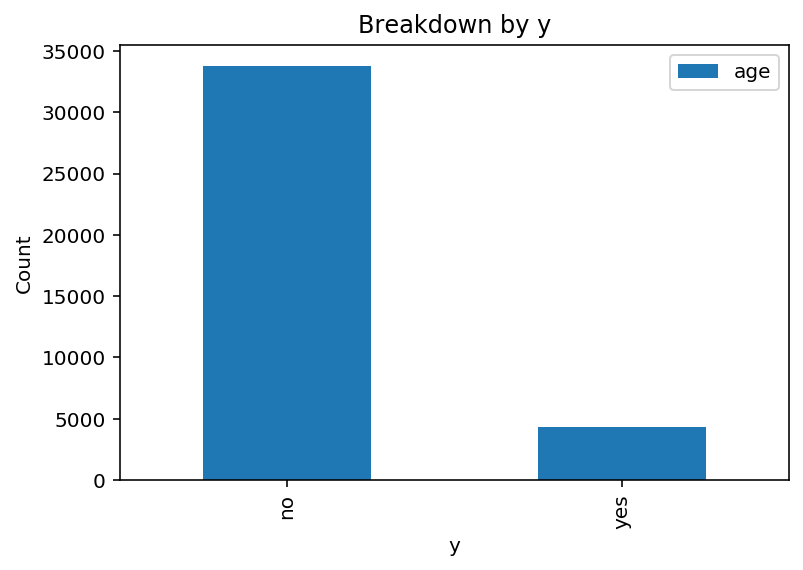

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

train_df[["y", "age"]].groupby("y").count().plot(kind="bar", title="Breakdown by y")
plt.xlabel("y")
plt.ylabel("Count")

We are not going to deal with this issue, we want to explore the capabilities of SageMaker AutoPilot even with this kind of datasets.

## Setting up the SageMaker AutoPilot job
Once the dataset is uploaded to S3, we can define a SageMaker AutoPilot job to find the best ML pipeline to train a model on this dataset.

The required inputs for invoking a SageMaker AutoML job are the dataset location in S3, the name of the column of the dataset you want to predict (y in this case) and an IAM role

In [10]:
sess   = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'learn-sagemaker'                     
prefix = 'bank_marketing'
input_path = 's3://{}/{}/train'.format(bucket,prefix)
output_path = 's3://{}/{}/sdk-output'.format(bucket,prefix)
print(input_path)
print(output_path)

s3://learn-sagemaker/bank_marketing/train
s3://learn-sagemaker/bank_marketing/sdk-output


In [11]:
auto_ml_job = AutoML(
    role = role,                                              # IAM permissions for SageMaker
    sagemaker_session = sess,                                 # Session
    target_attribute_name = 'y',                              # The column we want to predict
    output_path = output_path,                                # Save artifacts here
    max_runtime_per_training_job_in_seconds = 600,
    max_candidates = 50,
    total_job_runtime_in_seconds = 1800,
    generate_candidate_definitions_only=False,
    problem_type=None
)

We can now launch the job by calling the fit() API, setting the input data and the job name.

In [12]:
s3_input_data = AutoMLInput(input_path, 'y', compression=None)

In [13]:
auto_ml_job.fit(inputs=s3_input_data, logs=False, wait=False, job_name='bank-marketing-sdk')

Show the job properties

In [14]:
job = auto_ml_job.describe_auto_ml_job()
print(job)

{'AutoMLJobName': 'bank-marketing-sdk', 'AutoMLJobArn': 'arn:aws:sagemaker:us-east-2:223817798831:automl-job/bank-marketing-sdk', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://learn-sagemaker/bank_marketing/train'}}, 'TargetAttributeName': 'y'}], 'OutputDataConfig': {'S3OutputPath': 's3://learn-sagemaker/bank_marketing/sdk-output'}, 'RoleArn': 'arn:aws:iam::223817798831:role/service-role/AmazonSageMaker-ExecutionRole-20210510T201989', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 50, 'MaxRuntimePerTrainingJobInSeconds': 600, 'MaxAutoMLJobRuntimeInSeconds': 1800}, 'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}}, 'CreationTime': datetime.datetime(2021, 6, 20, 16, 50, 13, 140000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2021, 6, 20, 16, 51, 25, 741000, tzinfo=tzlocal()), 'AutoMLJobStatus': 'InProgress', 'AutoMLJobSecondaryStatus': 'AnalyzingData', 'GenerateCandidateDefinitionsOnly': False, 'R

Once feature engineering is complete, some different candidate models are tuned. While model tuning is running, we can explore its progress with SageMaker Experiments.

In [ ]:
from sagemaker.analytics import ExperimentAnalytics

exp = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=job['AutoMLJobName'] + '-aws-auto-ml-job'
)

df = exp.dataframe()
print("Number of jobs: ", len(df))

# Move metric to first column
df = pd.concat([df['ObjectiveMetric - Max'], df.drop(['ObjectiveMetric - Max'], axis=1)], axis=1)
# Show top 5 jobs
df.sort_values('ObjectiveMetric - Max', ascending=0)[:5]

## Deploying and testing the best candidate

Now that we have successfully completed the AutoPilot job, we can create a model from any of the trials with a single API call and then deploy that model for online or batch prediction. In this notebook, we deploy only the best performing model for inference.

The best candidate is the one we're really interested in.


Create the SageMaker session

In [17]:
sess   = sagemaker.Session()

View the AutoPilot job name you want to retrive the best performing model from the Experiments console and attach it a automl job variable

In [18]:
auto_ml_job_name = 'bank-marketing'

In [19]:
# Select the AutmoML job you want to restore
auto_ml_job_name = 'bank-marketing'
# Attach it to the AutoML object
auto_ml_job = AutoML.attach(auto_ml_job_name, sagemaker_session=sess)
# Describe the AutoML job
auto_ml_job.describe_auto_ml_job()

{'AutoMLJobName': 'bank-marketing',
 'AutoMLJobArn': 'arn:aws:sagemaker:us-east-2:223817798831:automl-job/bank-marketing',
 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 's3://learn-sagemaker/bank_marketing/train/train_full.csv'}},
   'TargetAttributeName': 'y'}],
 'OutputDataConfig': {'S3OutputPath': 's3://learn-sagemaker/bank_marketing/autopilot-outputs/'},
 'RoleArn': 'arn:aws:iam::223817798831:role/service-role/AmazonSageMaker-ExecutionRole-20210510T201989',
 'AutoMLJobObjective': {'MetricName': 'F1'},
 'ProblemType': 'BinaryClassification',
 'AutoMLJobConfig': {'CompletionCriteria': {'MaxRuntimePerTrainingJobInSeconds': 3600}},
 'CreationTime': datetime.datetime(2021, 5, 30, 9, 48, 5, 325000, tzinfo=tzlocal()),
 'EndTime': datetime.datetime(2021, 5, 30, 12, 21, 27, 864000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 5, 30, 12, 21, 27, 898000, tzinfo=tzlocal()),
 'BestCandidate': {'CandidateName': 'tuning-job-1-e36c

List the model candidates selected for this experiment

In [16]:
# To List model candidates
#auto_ml_job.list_candidates()

Extract the best candidate and show its properties

In [20]:
job_best_candidate = auto_ml_job.best_candidate()
print(job_best_candidate['CandidateName'])
print(job_best_candidate['FinalAutoMLJobObjectiveMetric'])

tuning-job-1-e36cc453689b4e9498-146-f5eacb03
{'MetricName': 'validation:f1', 'Value': 0.7900699973106384}


## Deploy the endpoint for the best candidate model

Set the endpoint name, adding a timestamp to the automl job name, now it is unique and can be deployed.

In [21]:
from time import strftime, gmtime

timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = auto_ml_job_name+'-'+timestamp
print('Endpoint: ',endpoint_name)

Endpoint:  bank-marketing-20-17-00-48


Now, we can deploy the endpoint containing our best candidate model

In [22]:
auto_ml_job.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.t2.medium',
    endpoint_name = endpoint_name
)

-----------------!

## Testing the best candidate model

Let's predict some test examples to test that our model endpoint is working fine. Our test dataset contains 3.090 rows or examples. It is not a great deal to handle this count of examples just invoking the endpoint. When we need to predict much more examples we should call a Batch Transform job.

To evaluate the model performance we load a test dataset and will make predictions on its examples, then we will calculate the performance metrics like accuracy or precision or recall.

First, we load the test dataset into a Dataframe and drop the target column.

In [23]:
# Read the test dataset
test_df= pd.read_csv('test.csv', header=0)
# Store the true labels for latter use
labels = test_df['y'].values
# Drop the target column
test_df.drop('y', axis=1, inplace=True)
test_df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,41,services,married,high.school,unknown,yes,no,cellular,nov,thu,255,2,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8
1,41,blue-collar,married,high.school,no,yes,no,cellular,nov,tue,77,1,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8
2,47,admin.,married,university.degree,no,no,no,cellular,aug,fri,451,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
3,31,housemaid,married,basic.4y,no,no,yes,cellular,aug,tue,129,6,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1
4,47,blue-collar,married,unknown,no,yes,no,cellular,may,mon,100,1,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1


In [43]:
# Select just a bunch of examples to test if needed
#test_df = test_df[:2000]
#test_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,41,services,married,high.school,unknown,yes,no,cellular,nov,thu,255,2,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8
1,41,blue-collar,married,high.school,no,yes,no,cellular,nov,tue,77,1,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8
2,47,admin.,married,university.degree,no,no,no,cellular,aug,fri,451,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
3,31,housemaid,married,basic.4y,no,no,yes,cellular,aug,tue,129,6,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1
4,47,blue-collar,married,unknown,no,yes,no,cellular,may,mon,100,1,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,51,services,divorced,basic.6y,unknown,no,yes,telephone,may,wed,114,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
1996,36,blue-collar,single,basic.4y,no,yes,no,telephone,may,mon,143,4,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1997,37,technician,single,high.school,no,yes,no,cellular,apr,thu,44,2,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1
1998,30,student,single,professional.course,no,yes,no,cellular,sep,mon,1616,4,19,1,success,-1.1,94.199,-37.5,0.879,4963.6


To invoke the endpoint deployed, we will call the boto3 package to invoke the endpoint just deployed.

In [24]:
import io
#Using Boto3
import boto3
#Create a sm runtime
sm_runtime = boto3.client("sagemaker-runtime")
#Create a payload
payload = io.StringIO()
# Move the test_df dataframe to 
test_df.to_csv(payload, header=None, index=None)
# Invoke the endpoint to get the predictions
response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload.getvalue(),
    ContentType='text/csv',
    Accept='text/csv')

Decode the response to extract the predictions

In [25]:
# Decode the response and split into a list 
response_body =response["Body"].read().decode("utf-8")
preds = response_body.split('\n')
# We must discard the last element of the list, it is just an empty string
preds=preds[:-1]
len(preds)

3090

Plot the confussion matrix and calculate the evaluation metrics to check the performance of the model on the test dataset

              precision    recall  f1-score   support

          no       0.98      0.91      0.94      2742
         yes       0.54      0.86      0.66       348

    accuracy                           0.90      3090
   macro avg       0.76      0.88      0.80      3090
weighted avg       0.93      0.90      0.91      3090



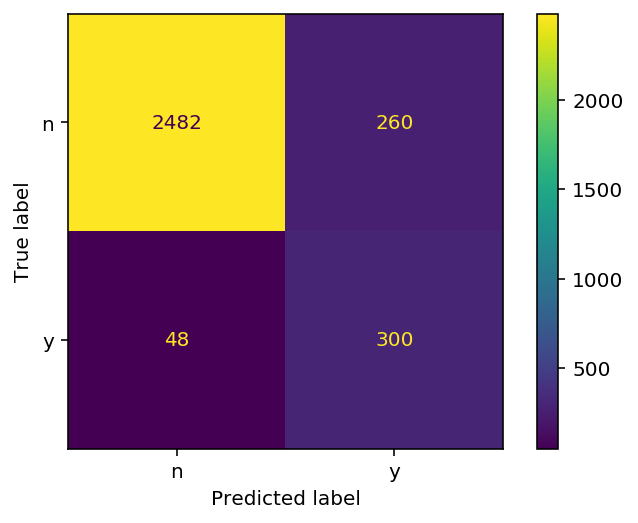

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get the metrics of our evaluation 
print(classification_report(labels, preds))
# Calculate the confussion matrix
cm = confusion_matrix(labels, preds) #, labels=['n','y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['n','y'])
disp.plot(values_format='d') 

We can see that the metrics for the mayority class are extremely high but for the minority class, precision is very bad. It looks lke AutoPilot does not take care of this issue, for unbalanced datasets we should apply some techniques to fix this situation before executing the AutoML project.

We show the confussion matrix, FP (False positives) are very high but the results are good.

## Deleting the endpoint¶
Now, we can delete the endpoint (and stop paying for it). **Be sure to execute this step!!**

In [32]:
sess.delete_endpoint(endpoint_name)